In [ ]:
import pandas as pd
import prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_excel("/content/Coffee Shop Sales (1).xlsx")
df.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


In [ ]:
#df.isnull().sum()
df.dtypes

,0
transaction_id,int64
transaction_date,datetime64[ns]
transaction_time,object
transaction_qty,int64
store_id,int64
store_location,object
product_id,int64
unit_price,float64
product_category,object
product_type,object


In [ ]:
df['transaction_time'] = pd.to_datetime(df['transaction_time'], format = '%H:%M:%S')
df.dtypes

,0
transaction_id,int64
transaction_date,datetime64[ns]
transaction_time,datetime64[ns]
transaction_qty,int64
store_id,int64
store_location,object
product_id,int64
unit_price,float64
product_category,object
product_type,object


In [ ]:
df.duplicated().sum()


np.int64(0)

In [ ]:
df['Total_sales'] = df['transaction_qty'] * df['unit_price']
df['Total_sales']

,Total_sales
0,6.00
1,6.20
2,9.00
3,2.00
4,6.20
...,...
149111,5.00
149112,6.00
149113,3.00
149114,3.75


Time Series Forecasting (Per Product / Time Slot)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptotwq5ws/bgb2qqhv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptotwq5ws/zztg2kpt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98143', 'data', 'file=/tmp/tmptotwq5ws/bgb2qqhv.json', 'init=/tmp/tmptotwq5ws/zztg2kpt.json', 'output', 'file=/tmp/tmptotwq5ws/prophet_model1htutmw6/prophet_model-20250811073138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:31:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:31:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


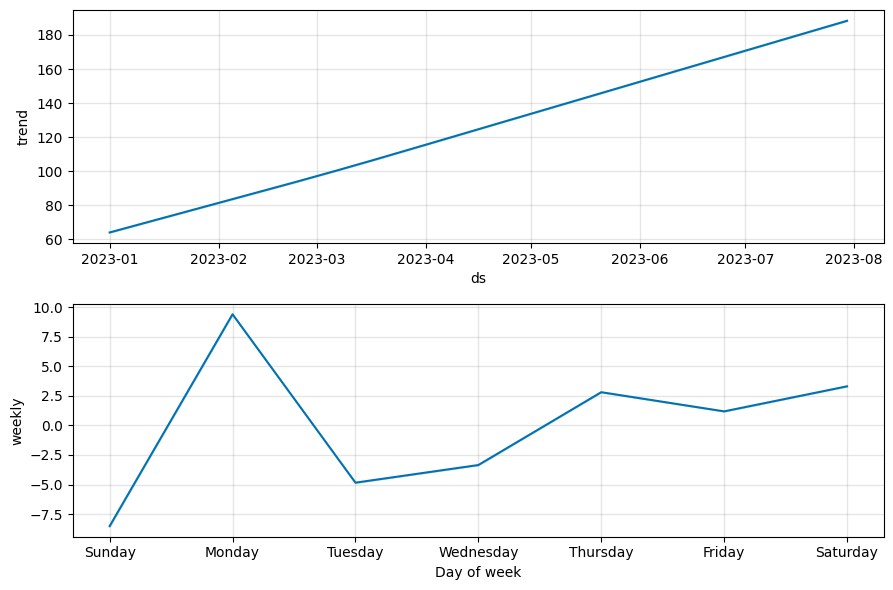

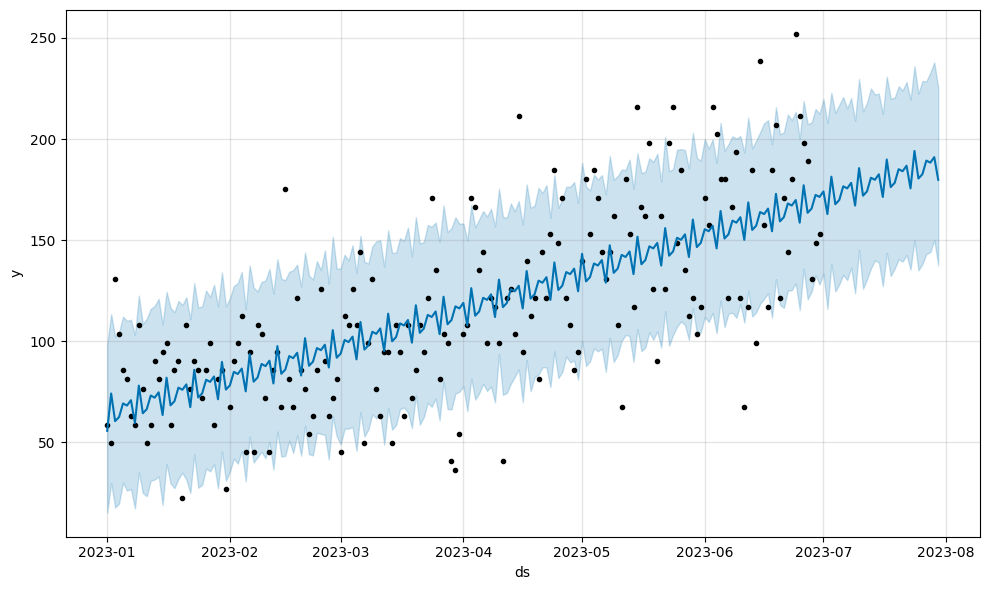

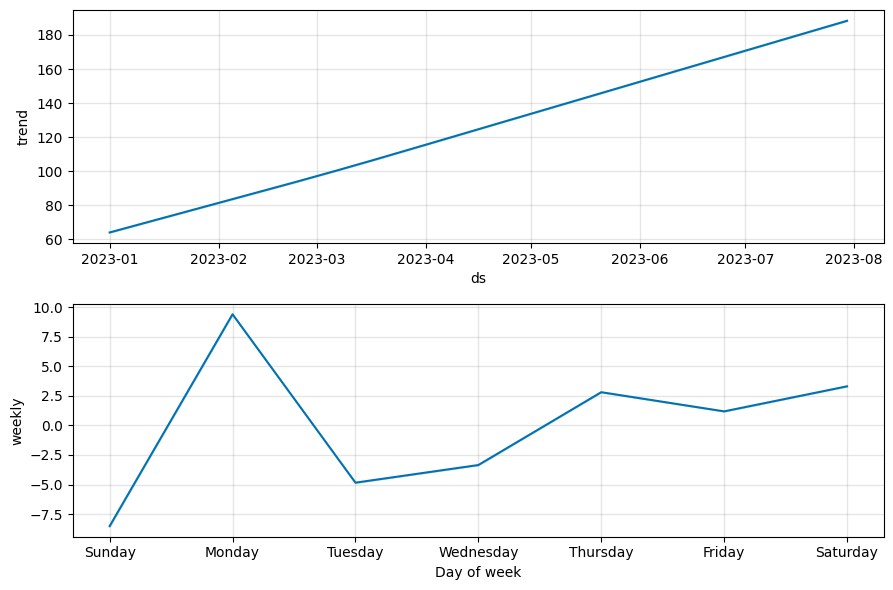

In [ ]:
product_id = 59 #Enter product id here

df_product = df[df['product_id'] == product_id]
sales_per_day = df_product.groupby('transaction_date')['Total_sales'].sum().reset_index()
sales_per_day.columns = ['ds', 'y']

m = prophet.Prophet()
m.fit(sales_per_day)

future = m.make_future_dataframe(periods = 30)
forcast = m.predict(future)

m.plot(forcast)
m.plot_components(forcast)

Tree-Based Regression:

In [ ]:
df['profit'] = df['transaction_qty'] * df['unit_price']

le = LabelEncoder()
for col in ['store_location', 'product_category', 'product_type', 'product_detail']:
    df[col] = le.fit_transform(df[col])
X = df[['transaction_qty', 'unit_price', 'store_id', 'store_location', 'product_id', 'product_category', 'product_type']]
y = df['profit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importance)

            Feature    Importance
0   transaction_qty  6.136339e-01
1        unit_price  3.851959e-01
4        product_id  9.217265e-04
6      product_type  1.591705e-04
5  product_category  8.930220e-05
3    store_location  4.646901e-15
2          store_id  4.589093e-15


In [ ]:
monthly_sales = df.groupby(pd.Grouper(key='transaction_date', freq='M'))['Total_sales'].sum().reset_index()
monthly_sales.set_index('transaction_date', inplace=True)

display(monthly_sales.head())

/tmp/ipython-input-3690535276.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.groupby(pd.Grouper(key='transaction_date', freq='M'))['Total_sales'].sum().reset_index()


,Total_sales
transaction_date,
2023-01-31,81677.74
2023-02-28,76145.19
2023-03-31,98834.68
2023-04-30,118941.08
2023-05-31,156727.76


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


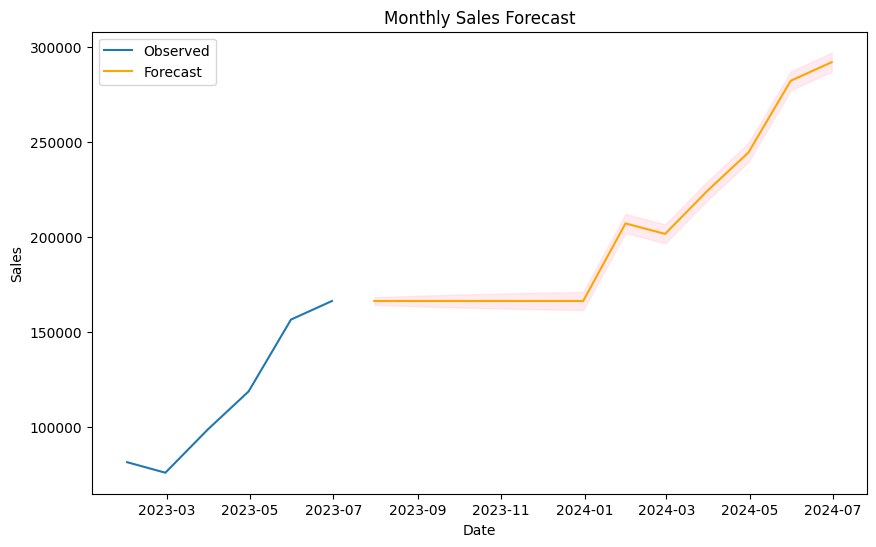

In [ ]:
model = SARIMAX(monthly_sales['Total_sales'], order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit(disp=False)

forecast_steps = 12
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()

plt.figure(figsize=(10,6))
plt.plot(monthly_sales.index, monthly_sales['Total_sales'], label='Observed')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast', color='orange')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1], color='pink', alpha=0.3)
plt.title('Monthly Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()